
# Credit Risk Classification 

#### Goal  
   - Predict if a bank should accept or reject a loan application of an individual (binary classification)


#### Challenges
   - The dataset is highly unbalanced.
   - The raw dataset has over 90 features.
       - What are we going to use to predict this rating?  
   - What is the proper algorithm we should use for this model?  
       - How to improve the accuracy of our prediction? 
   - The dataset is large.

#### Summary:  
   - This notebook is focusing on classification. Algorithms include:
       - Random Forests
       - Naive Bayes
       - XGBoost
   - We will optimize each algorithm as much as possible.
   - We will go over the basic process of ML modeling. But in practice, the process varies. 
   
# Notebook Structure :
    
   - **An Overview of the dataset**
     - Project scope
     - Project goal
   - **Clean the data**
     - Null values handling
     - Categorical features handling
   - **Evaluate algorithms using raw data**
     - Logistic  Regression
     - KNN
     - Support Vector Machine
     - Random Forests
     - naive bayes
   - **Preprocessing**
       - Create new features
       - Feature importance for binary classification
   - **Model Optimization**
       - Confusion Matrix
       - Recall and Precision 
   - **_Article: Pro & Cons for different algorithms_**
       

### ----Content Starts here-----


#### Import necessary library and define class and functions to operate faster

In [468]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Define some functions that could help us operate faster. 

In [469]:
def value_counts(cols):
    value_counts = cols.value_counts(dropna = False )
    return value_counts

def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns
    
def check_null(df):
    all_cols = df.isnull().sum().sort_values(ascending = False)
    null_cols = all_cols[all_cols > 0]
    return null_cols

def check_null_percent(df):
    null_cols = check_null(df)
    null_percent = ((null_cols / len(df))* 100).round(2)
    return null_percent

def index_to_list(df):
    index_to_list = df.index.to_list()
    return index_to_list

def drop_cols(df, cols):
    df = df.drop(cols, axis = 1)
    return df

def drop_threshold_cols(df, threshold):
    null_percent = check_null_percent(df)
    over_threshold_col = null_percent[null_percent > threshold]
    over_threshold_col = index_to_list(over_threshold_col)
    df = df.drop(over_threshold_col, axis = 1)
    return df

def fill_cols_zero(df, cols):
    df[cols] = df[cols].fillna(value=0)
    return df

def fill_cols_mode(df, cols):
    for col in cols:
        df[col] = df[col].fillna(df[col].mode()[0])
    return df

def fill_cols_mean(df, cols):
    for col in cols:
        df[col] = df[col].fillna(df[col].mean())
    return df

def check_start(df, cols, vals):
    lst = []
    for col in cols:
        for val in vals:
            if col.startswith(val):
                lst.append(col)
    return lst

def check_end(df, cols, vals):
    lst = []
    for col in cols:
        for val in vals:
            if col.endswith(val):
                lst.append(col)
    return lst

def return_cat_cols(df):
    cat_cols = df.select_dtypes(include='object').columns.to_list()
    return cat_cols

def check_cat_cols(df):
    cat_cols = df.select_dtypes(include='object').columns.to_list()
    for col in cat_cols:
        print('{} has {} levels\n'.format(col, len(df[col].value_counts(ascending=True))))

def train_test_split(df, test_size:float):
    from sklearn.model_selection import train_test_split, cross_val_score
    from sklearn.preprocessing import StandardScaler
    X = df.iloc[:,1:]
    y = df.iloc[:,0] 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.fit_transform(X_test)
    return X_train, X_test, y_train, y_test

def min_max_scaler_X(X_train, X_test):
    from sklearn.preprocessing import StandardScaler
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.fit_transform(X_test)
    
    
    
# def plot_confusion_matrix(model):
#     from sklearn.metrics import plot_confusion_matrix
#     np.set_printoptions(precision=2)
#     titles_options = [("Confusion matrix, without normalization", None),
#                       ("Normalized confusion matrix", 'true')]
#     for title, normalize in titles_options:
#         disp = plot_confusion_matrix(model, X_test, y_test,
#                                      display_labels=[0,1],
#                                      cmap=plt.cm.Greys,
#                                      normalize=normalize)
#         disp.ax_.set_title(title)
#     plt.show()

# def f1_score(model):
#     from sklearn.metrics import f1_score
#     y_pred = model.predict(X_test)
#     f1_score = f1_score(y_test, y_pred).round(2)
#     print('f1 score is: {}'.format(f1_score))

In [470]:
path = 'C:\\Users\\ron.luo\\Documents\\Default Risk'
raw_file ='application_train.csv'
os.chdir(path)
source = pd.read_csv(raw_file, header = 0, index_col=False, engine='python')

In [472]:
df = source.copy()

## EDA

#### Target Values

Very obvious is that the dataset is imbalanced. The ratio of target 1 and target 0 loos almost 1: 10.

<AxesSubplot:xlabel='TARGET', ylabel='count'>

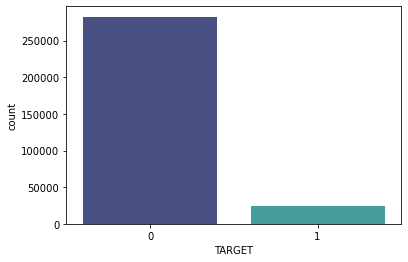

In [12]:
sns.countplot(data=df, x='TARGET', palette='mako')

#### Missing Values

From the table below, we saw that some of the features have a high percentage of missing value.   
We could drop them of fill them, but either method introduce issues (biases / lost important information).  
For now, we will let them go.


In [13]:
# missing_values_table(df)

In [7]:
### Add this line for testing
# df = drop_threshold_cols(df, 50)

#### Understand the distribution of continuous columns.
_The cell below is comment out. Its purpose is to look at the distribution of each continuous feature group by Target._

In [8]:
# ncols = 3
# nrows = 21

# ## Draw a graph with 3 cols x 21 rows and size of 40 x 250
# fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize = (40,250))  

# for row in range(nrows):
#     for col in range(ncols):
#         ax = axs[row][col]
#         i = row*ncols + col  #### Go over all the index
        
#         if i < len(null_list) and df[null_list[i]].dtype != 'object':   ### Check if a column is categorical
#             sns.kdeplot(data=df, x=df.loc[(df['TARGET'] == 1), 
#                 null_list[i]], color = 'orange', shade = True, label = 'Class 1', ax = ax, bw_adjust=3)
#             sns.kdeplot(data=df, x=df.loc[(df['TARGET'] == 0), 
#                        null_list[i]], shade = True, color = 'blueviolet', label = 'Class 0', ax = ax, bw_adjust=5)
#             ax.set_title('{}'.format(null_dict[null_list[i]]))

By eyeballing the distribution of each continuous variable, we see three of them are very different - 'EXT_SOURCE_1' and 'EXT_SOURCE_2', 'EXT_SOURCE_3'. Take a closer look

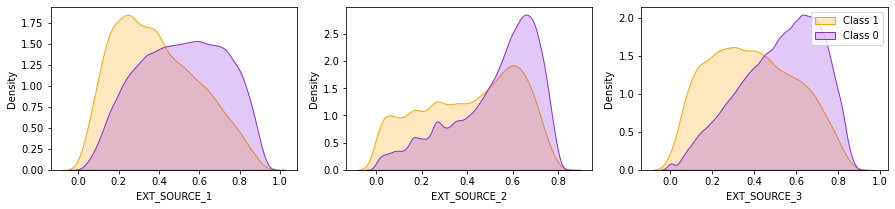

In [474]:
fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize = (15,3))

sns.kdeplot(data=df, x=df.loc[(df['TARGET'] == 1), 
            'EXT_SOURCE_1'], color = 'orange', shade = True, label = 'Class 1', ax = ax1)
sns.kdeplot(data=df, x=df.loc[(df['TARGET'] == 0), 
            'EXT_SOURCE_1'], color = 'blueviolet', shade = True, label = 'Class 0', ax = ax1)


sns.kdeplot(data=df, x=df.loc[(df['TARGET'] == 1), 
           'EXT_SOURCE_2'], color = 'orange', shade = True, label = 'Class 1', ax = ax2)

sns.kdeplot(data=df, x=df.loc[(df['TARGET'] == 0), 
           'EXT_SOURCE_2'], color = 'blueviolet', shade = True, label = 'Class 0', ax = ax2)

sns.kdeplot(data=df, x=df.loc[(df['TARGET'] == 1), 
           'EXT_SOURCE_3'], color = 'orange', shade = True, label = 'Class 1', ax = ax3)
sns.kdeplot(data=df, x=df.loc[(df['TARGET'] == 0), 
           'EXT_SOURCE_3'], color = 'blueviolet', shade = True, label = 'Class 0', ax = ax3)

plt.legend()

##### We may also want to find some interesting numbers among the features

Looking at the distribution of applicant’s annual income, turn out that the distribution is extremely imbalanced. This graph told us that that are some extreme values in the applicant's annual income. The boxplot below showed us the similar information: the outliner is far away from most of the people.

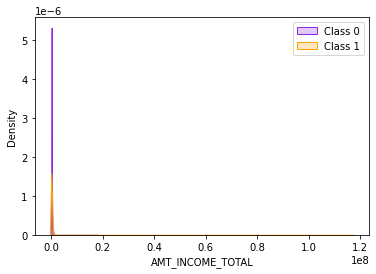

In [475]:
sns.kdeplot(data=df, x=df.loc[(df['TARGET'] == 0), 
           'AMT_INCOME_TOTAL'], color = 'blueviolet', shade = True, label = 'Class 0', bw_adjust=2)
sns.kdeplot(data=df, x=df.loc[(df['TARGET'] == 1), 
           'AMT_INCOME_TOTAL'], color = 'orange', shade = True, label = 'Class 1', bw_adjust=2)
plt.legend()

<AxesSubplot:xlabel='AMT_INCOME_TOTAL'>

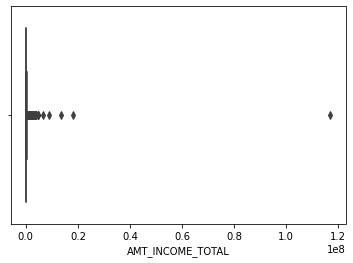

In [476]:
sns.boxplot(data = df, x = df['AMT_INCOME_TOTAL'], hue = ['TARGET'])

Convert the **[Age]** into **[Age_Group]**

In [477]:
df['DAYS_BIRTH'] = abs(df['DAYS_BIRTH'])
df['AGE'] = (df['DAYS_BIRTH'] // 365)
bins = [10,20,30,40,50,60,70,80,90]
labels = ["(10,20)","(20,30)","(30,40)", "(40,50)","(50,60)","(60,70)","(70,80)","(80,90)"]
df['AGE_GROUP'] = pd.cut(df['AGE'], bins=bins, labels=labels)

We want to see how each age group perform. It turned out that the default risk decreases by **[Age_Group]**.

<AxesSubplot:xlabel='levels', ylabel='%'>

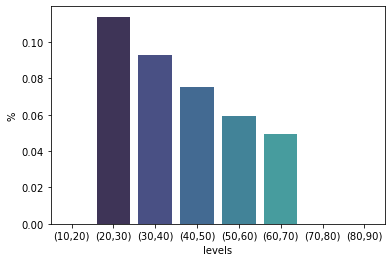

In [478]:
target_count = df[(df['TARGET'] == 1)]['AGE_GROUP'].value_counts()  ## AGE_GROUP Value count when Target = 1
feature_count = df['AGE_GROUP'].value_counts()  ##AGE_GROUP count in the entire dataset
ratio = target_count / feature_count
ratio = ratio.to_frame().reset_index()
ratio = ratio.rename(columns= {'index': 'levels', 'AGE_GROUP': '%'})
sns.barplot(data = ratio, x = 'levels', y = '%', palette = 'mako')

Same pattern could be seen by the feature **['REGION_RATING_CLIENT_W_CITY']**. Applicant living in the city rated '3' is more likely to default a loan.

<AxesSubplot:xlabel='levels', ylabel='%'>

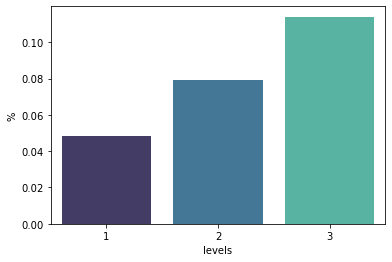

In [480]:
target_count = df[(df['TARGET'] == 1)]['REGION_RATING_CLIENT_W_CITY'].value_counts()  ## AGE_GROUP Value count when Target = 1
feature_count = df['REGION_RATING_CLIENT_W_CITY'].value_counts()  ##AGE_GROUP count in the entire dataset
ratio = target_count / feature_count
ratio = ratio.to_frame().reset_index()
ratio = ratio.rename(columns= {'index': 'levels', 'REGION_RATING_CLIENT_W_CITY': '%'})
sns.barplot(data = ratio, x = 'levels', y = '%', palette = 'mako')

A reversed trend can be seen in the **[EDUCATION_TYPE]**. People with a higher education type will be a safe bet.

<AxesSubplot:xlabel='levels', ylabel='%'>

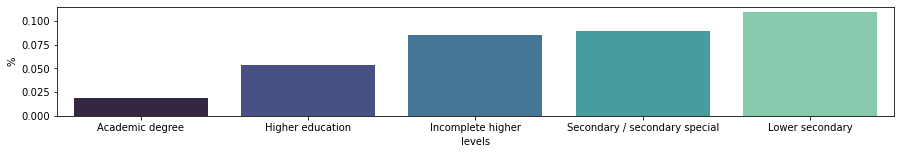

In [481]:
target_count = df[(df['TARGET'] == 1)]['NAME_EDUCATION_TYPE'].value_counts()  ## AGE_GROUP Value count when Target = 1
feature_count = df['NAME_EDUCATION_TYPE'].value_counts()  ##AGE_GROUP count in the entire dataset
fig, ax = plt.subplots(figsize = (15, 2))
ratio = (target_count / feature_count).sort_values(ascending = True)
ratio = ratio.to_frame().reset_index()
ratio = ratio.rename(columns= {'index': 'levels', 'NAME_EDUCATION_TYPE': '%'})
sns.barplot(data = ratio, x = 'levels', y = '%', palette = 'mako')

Looking at **'DAY_EMPLOYED'**, the distribution is strange. A lot of people have a value of **365243**, but other than this all people have a negative values around **-200**.

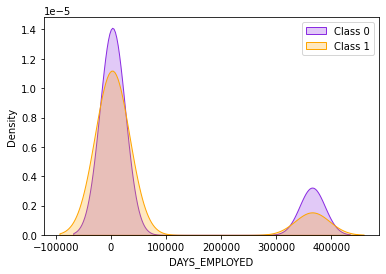

In [482]:
df['DAYS_EMPLOYED'] = abs(df['DAYS_EMPLOYED'])
sns.kdeplot(data=df, x=df.loc[(df['TARGET'] == 0), 
           'DAYS_EMPLOYED'], color = 'blueviolet', shade = True, label = 'Class 0', legend=True, bw_adjust=2)
sns.kdeplot(data=df, x=df.loc[(df['TARGET'] == 1), 
           'DAYS_EMPLOYED'], color = 'orange', shade = True, label = 'Class 1', legend=True, bw_adjust=2)
plt.legend()

In [483]:
df['DAYS_EMPLOYED_CLASS'] = np.where(df['DAYS_EMPLOYED']!= 365243, 1, 0)

<AxesSubplot:xlabel='levels', ylabel='%'>

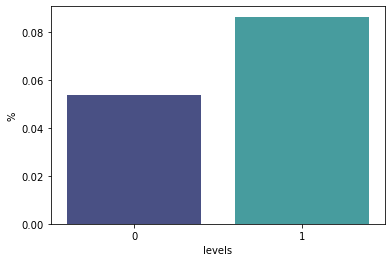

In [484]:
target_count = df[(df['TARGET'] == 1)]['DAYS_EMPLOYED_CLASS'].value_counts()  ## AGE_GROUP Value count when Target = 1
feature_count = df['DAYS_EMPLOYED_CLASS'].value_counts()  ##AGE_GROUP count in the entire dataset
ratio = target_count / feature_count
ratio = ratio.to_frame().reset_index()
ratio = ratio.rename(columns= {'index': 'levels', 'DAYS_EMPLOYED_CLASS': '%'})
sns.barplot(data = ratio, x = 'levels', y = '%', palette = 'mako')

By using the barplot, it turned out that those having an extreme value are more likely to default a loan. 

### 1.3 Feature Enginnering

From EDA, we have already created two new features: **['AGE_GROUP']** and **['DAYS_EMPLOYED_CLASS']**. And we are going to create more in this part. 

**[Total Document Received]**: columns start with 'FLAG_DOCUMENT' means if an applicant submit a document. We are going to sum these columns to get the total number of document received.

In [485]:
DOC_cols = check_start(df,df.columns,["FLAG_DOCUMENT"])
df['TOTAL_DOC'] = df[DOC_cols].sum(axis=1)

**[Total Query]**: columns start with "AMT_REQ_CREDIT_BUREAU" means how many query an applicant send. We are going to sum these as well.

In [486]:
QUERY_cols = check_start(df,df.columns,["AMT_REQ_CREDIT_BUREAU"])
df['TOTAL_QUERY'] = df[QUERY_cols].sum(axis=1)

**[Total Contact]**: we are going to sum how many contact methods the applicant provided

In [487]:
CONTACT_cols = check_end(df,df.columns,["PHONE","MOBILE","EMAIL"])
df['TOTAL_CONTACT'] = df[CONTACT_cols].sum(axis=1)

**[Social Circle Default Total]**: we are going to check the number that how many people in the applicant's social circle default the loan.

In [488]:
CIRCLE_cols =  check_end(df,df.columns,["CIRCLE"])
df['CIRCLE'] = df[CIRCLE_cols].sum(axis = 1)

### Handle Missing Values  


**Note**: though some algorhithms can handle or ignore missing values, it is in general a good idea to make your data as clean as possible.

<!--  ##### - 1.1.1 Set up threshold to drop columns with more than 25% of null values
 
  In general, if a column has more than 25% of missing values, it can be dropped safely. -->

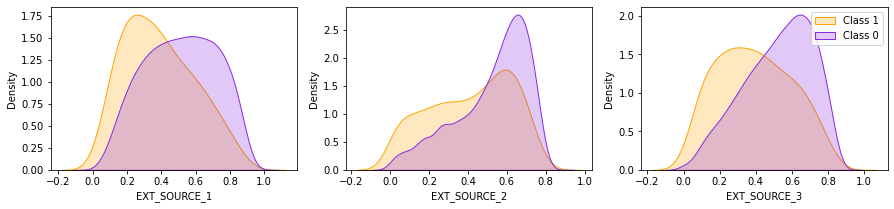

In [489]:
fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize = (15,3))

sns.kdeplot(data=df, x=df.loc[(df['TARGET'] == 1), 
            'EXT_SOURCE_1'], color = 'orange', shade = True, label = 'Class 1', ax = ax1, bw_adjust=2)
sns.kdeplot(data=df, x=df.loc[(df['TARGET'] == 0), 
            'EXT_SOURCE_1'], color = 'blueviolet', shade = True, label = 'Class 0', ax = ax1, bw_adjust=2)


sns.kdeplot(data=df, x=df.loc[(df['TARGET'] == 1), 
           'EXT_SOURCE_2'], color = 'orange', shade = True, label = 'Class 1', ax = ax2, bw_adjust=2)

sns.kdeplot(data=df, x=df.loc[(df['TARGET'] == 0), 
           'EXT_SOURCE_2'], color = 'blueviolet', shade = True, label = 'Class 0', ax = ax2, bw_adjust=2)

sns.kdeplot(data=df, x=df.loc[(df['TARGET'] == 1), 
           'EXT_SOURCE_3'], color = 'orange', shade = True, label = 'Class 1', ax = ax3, bw_adjust=2)
sns.kdeplot(data=df, x=df.loc[(df['TARGET'] == 0), 
           'EXT_SOURCE_3'], color = 'blueviolet', shade = True, label = 'Class 0', ax = ax3, bw_adjust=2)

plt.legend()

**Fill missing values by columns mean (Bad Idea)**

In [490]:
df2 = df[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].copy()

In [491]:
df_column_mean = df2.copy()

In [492]:
EXT_cols = check_start(df_column_mean,df_column_mean.columns, ['EXT_SOURCE'])
for col in EXT_cols:
    df_column_mean[col] = df_column_mean[col].fillna(df_column_mean[col].mean())

<AxesSubplot:xlabel='EXT_SOURCE_3', ylabel='Density'>

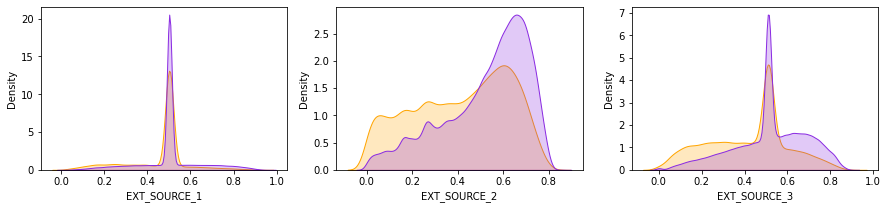

In [503]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 3))
sns.kdeplot(data=df_column_mean, x=df_column_mean.loc[(df_column_mean['TARGET'] == 1), 
            'EXT_SOURCE_1'], color = 'orange', shade = True, label = 'Class 1', ax = ax1)
sns.kdeplot(data=df_column_mean, x=df_column_mean.loc[(df_column_mean['TARGET'] == 0), 
            'EXT_SOURCE_1'], color = 'blueviolet', shade = True, label = 'Class 0', ax = ax1)

sns.kdeplot(data=df_column_mean, x=df_column_mean.loc[(df_column_mean['TARGET'] == 1), 
            'EXT_SOURCE_2'], color = 'orange', shade = True, label = 'Class 1', ax = ax2)
sns.kdeplot(data=df_column_mean, x=df_column_mean.loc[(df_column_mean['TARGET'] == 0), 
            'EXT_SOURCE_2'], color = 'blueviolet', shade = True, label = 'Class 0', ax = ax2)

sns.kdeplot(data=df_column_mean, x=df_column_mean.loc[(df_column_mean['TARGET'] == 1), 
            'EXT_SOURCE_3'], color = 'orange', shade = True, label = 'Class 1', ax= ax3)
sns.kdeplot(data=df_column_mean, x=df_column_mean.loc[(df_column_mean['TARGET'] == 0), 
            'EXT_SOURCE_3'], color = 'blueviolet', shade = True, label = 'Class 0', ax = ax3)

**Fill missing values by columns mean by target**

In [494]:
df_column_target_mean = df2.copy()

In [495]:
TARGET_classes = [0,1]
EXT_cols

['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']

In [496]:
for t_class in TARGET_classes:
    for col in EXT_cols: 
        df_column_target_mean.loc[(df_column_target_mean['TARGET'] == t_class), col] = df_column_target_mean.loc[(df_column_target_mean['TARGET'] == t_class), col].fillna(df2[df2['TARGET'] == t_class][col].mean())

<AxesSubplot:xlabel='EXT_SOURCE_3', ylabel='Density'>

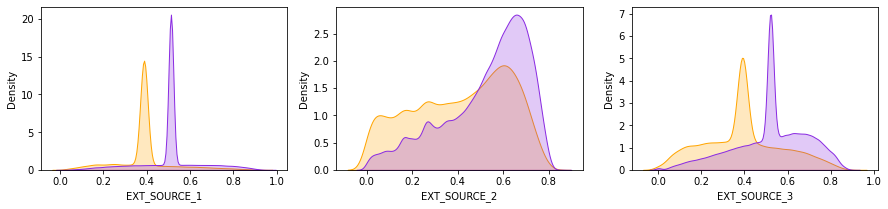

In [504]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 3))
sns.kdeplot(data=df_column_target_mean, x=df_column_target_mean.loc[(df_column_target_mean['TARGET'] == 1), 
            'EXT_SOURCE_1'], color = 'orange', shade = True, label = 'Class 1', ax = ax1)
sns.kdeplot(data=df_column_target_mean, x=df_column_target_mean.loc[(df_column_target_mean['TARGET'] == 0), 
            'EXT_SOURCE_1'], color = 'blueviolet', shade = True, label = 'Class 0', ax = ax1)

sns.kdeplot(data=df_column_target_mean, x=df_column_target_mean.loc[(df_column_target_mean['TARGET'] == 1), 
            'EXT_SOURCE_2'], color = 'orange', shade = True, label = 'Class 1', ax = ax2)
sns.kdeplot(data=df_column_target_mean, x=df_column_target_mean.loc[(df_column_target_mean['TARGET'] == 0), 
            'EXT_SOURCE_2'], color = 'blueviolet', shade = True, label = 'Class 0', ax = ax2)

sns.kdeplot(data=df_column_target_mean, x=df_column_target_mean.loc[(df_column_target_mean['TARGET'] == 1), 
            'EXT_SOURCE_3'], color = 'orange', shade = True, label = 'Class 1', ax= ax3)
sns.kdeplot(data=df_column_target_mean, x=df_column_target_mean.loc[(df_column_target_mean['TARGET'] == 0), 
            'EXT_SOURCE_3'], color = 'blueviolet', shade = True, label = 'Class 0', ax = ax3)

**Fill missing values using MICE**

In [498]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [500]:
df3 = df[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'+]]

In [501]:
df_mice_mean = df3.copy()
imp_mean = IterativeImputer(random_state=20,max_iter = 250)
imp_mean.fit(df_mice_mean)
k = imp_mean.transform(df_mice_mean)
k_pd = pd.DataFrame(k, columns = df3.columns)

<AxesSubplot:xlabel='EXT_SOURCE_3', ylabel='Density'>

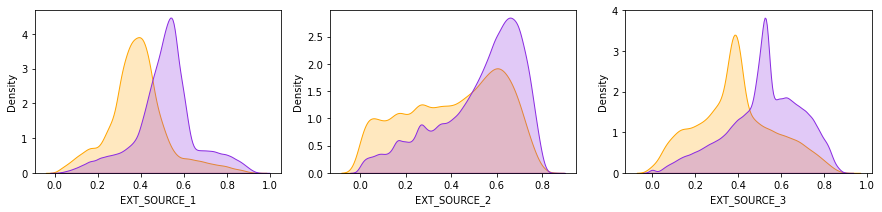

In [505]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 3))
sns.kdeplot(data=k_pd, x=k_pd.loc[(k_pd['TARGET'] == 1), 
            'EXT_SOURCE_1'], color = 'orange', shade = True, label = 'Class 1', ax = ax1)
sns.kdeplot(data=k_pd, x=k_pd.loc[(k_pd['TARGET'] == 0), 
            'EXT_SOURCE_1'], color = 'blueviolet', shade = True, label = 'Class 0', ax = ax1)

sns.kdeplot(data=k_pd, x=k_pd.loc[(k_pd['TARGET'] == 1), 
            'EXT_SOURCE_2'], color = 'orange', shade = True, label = 'Class 1', ax = ax2)
sns.kdeplot(data=k_pd, x=k_pd.loc[(k_pd['TARGET'] == 0), 
            'EXT_SOURCE_2'], color = 'blueviolet', shade = True, label = 'Class 0', ax = ax2)

sns.kdeplot(data=k_pd, x=k_pd.loc[(k_pd['TARGET'] == 1), 
            'EXT_SOURCE_3'], color = 'orange', shade = True, label = 'Class 1', ax= ax3)
sns.kdeplot(data=k_pd, x=k_pd.loc[(k_pd['TARGET'] == 0), 
            'EXT_SOURCE_3'], color = 'blueviolet', shade = True, label = 'Class 0', ax = ax3)

##### - 1.1.2 Fill each column accordingly

- Some feautes have a Null value indicating it is zero. For these features, we fill 0

Columns start with 'AMT_REQ' indicate the numbers of query an applicant sent. If it is Null, it means 0. We will fill 0 to these columns.

In [506]:
df_mice = df.copy()
MEDI_cols = check_end(df_mice, df_mice.columns, ['MEDI'])
AVG_cols = check_end(df_mice, df_mice.columns, ['AVG'])
CIRCLE_cols = check_end(df_mice, df_mice, ['CIRCLE'])
EXT_cols = check_start(df_mice, df_mice.columns, ['EXT'])
AMT_cols = check_start(df_mice, df_mice.columns, ['AMT'])
MODE_cols =  check_end(df_mice, df_mice.columns, ['MODE'])

In [507]:
for col in df[MODE_cols]:
    if df[col].dtypes == 'object':
        MODE_cols.remove(col)

In [508]:
All_cols = [MEDI_cols, AVG_cols, MODE_cols, CIRCLE_cols, EXT_cols, AMT_cols ]

In [509]:
# Based on experiement, MICE perform best when TARGET is included
for cols in All_cols:
    cols.append('TARGET')

In [510]:
df_temp = df.copy()

In [511]:
### This cell will take a while to process
for cols in All_cols:
    imp_mean = IterativeImputer(random_state=20,max_iter = 250)
    imp_mean.fit(df_mice[cols])
    df_mice_temp = imp_mean.transform(df_mice[cols])
    df_mice_temp = pd.DataFrame(df_mice_temp, columns = cols)
    df_temp[cols] = df_mice_temp

In [514]:
df = df_temp.copy()

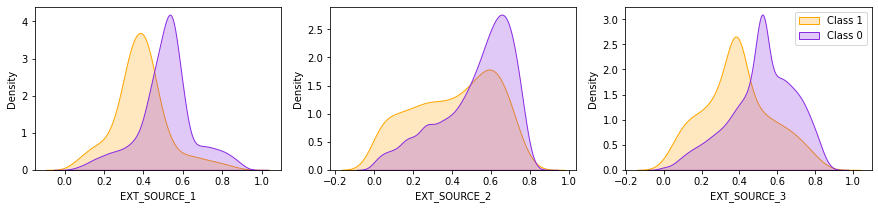

In [515]:
fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize = (15,3))

sns.kdeplot(data=df, x=df.loc[(df['TARGET'] == 1), 
            'EXT_SOURCE_1'], color = 'orange', shade = True, label = 'Class 1', ax = ax1, bw_adjust=2)
sns.kdeplot(data=df, x=df.loc[(df['TARGET'] == 0), 
            'EXT_SOURCE_1'], color = 'blueviolet', shade = True, label = 'Class 0', ax = ax1, bw_adjust=2)


sns.kdeplot(data=df, x=df.loc[(df['TARGET'] == 1), 
           'EXT_SOURCE_2'], color = 'orange', shade = True, label = 'Class 1', ax = ax2, bw_adjust=2)

sns.kdeplot(data=df, x=df.loc[(df['TARGET'] == 0), 
           'EXT_SOURCE_2'], color = 'blueviolet', shade = True, label = 'Class 0', ax = ax2, bw_adjust=2)

sns.kdeplot(data=df, x=df.loc[(df['TARGET'] == 1), 
           'EXT_SOURCE_3'], color = 'orange', shade = True, label = 'Class 1', ax = ax3, bw_adjust=2)
sns.kdeplot(data=df, x=df.loc[(df['TARGET'] == 0), 
           'EXT_SOURCE_3'], color = 'blueviolet', shade = True, label = 'Class 0', ax = ax3, bw_adjust=2)

plt.legend()

In [183]:
missing_values_table(df) ## The remaining columns still have missing values. We are going to drop them for now
other_cols = missing_values_table(df).index.to_list()
df = df.drop(other_cols, axis = 1)

Your selected dataframe has 124 columns.
There are 9 columns that have missing values.


,Missing Values,% of Total Values
FONDKAPREMONT_MODE,210295,68.4
OWN_CAR_AGE,202929,66.0
WALLSMATERIAL_MODE,156341,50.8
HOUSETYPE_MODE,154297,50.2
EMERGENCYSTATE_MODE,145755,47.4
OCCUPATION_TYPE,96391,31.3
NAME_TYPE_SUITE,1292,0.4
CNT_FAM_MEMBERS,2,0.0
DAYS_LAST_PHONE_CHANGE,1,0.0


#### 1.2 Handle Categorical Features

Check how many levels each categorical feature has

In [189]:
check_cat_cols(df)

NAME_CONTRACT_TYPE has 2 levels

CODE_GENDER has 3 levels

FLAG_OWN_CAR has 2 levels

FLAG_OWN_REALTY has 2 levels

NAME_INCOME_TYPE has 8 levels

NAME_EDUCATION_TYPE has 5 levels

NAME_FAMILY_STATUS has 6 levels

NAME_HOUSING_TYPE has 6 levels

WEEKDAY_APPR_PROCESS_START has 7 levels

ORGANIZATION_TYPE has 58 levels



In [192]:
cat_cols = df.select_dtypes(include = ['category','object']).columns.to_list()

In [193]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
cols_encoded = encoder.fit_transform(df[cat_cols])
encode_cols = encoder.get_feature_names(cat_cols)
enc_df = pd.DataFrame(cols_encoded.toarray(), columns = encode_cols )
frames = [df, enc_df]
df = pd.concat(frames, axis = 1, ignore_index=False)


In [194]:
final_df = df.drop(cat_cols, axis = 1).copy()

In [198]:
final_df.dtypes.value_counts()

float64    168
int64       41
dtype: int64

### Preparation before Algorithms Selection

In [419]:

#### K_Fold testing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

### Algorthims
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier

#Evaluation
from sklearn.metrics import roc_curve, auc, accuracy_score, roc_auc_score
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import f1_score

In [411]:
def plot_confusion_matrix(model):
    from sklearn.metrics import plot_confusion_matrix
    np.set_printoptions(precision=2)
    titles_options = [("Confusion matrix, without normalization", None),
                      ("Normalized confusion matrix", 'true')]
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(model, X_test, y_test,
                                     display_labels=[0,1],
                                     cmap=plt.cm.Greys,
                                     normalize=normalize)
        disp.ax_.set_title(title)
    plt.show()

    
def f1_score(model):
    from sklearn.metrics import f1_score
    y_pred = model.predict(X_test)
    f1_score = f1_score(y_test, y_pred).round(2)
    print('f1 score of {} is: {}'.format(models_dict[model], f1_score))

##### Downsampling

In [424]:
ratio_num = input('Do you want to downsampling (int / no): ')
if ratio_num != 'no':
    ratio = ratio_num
    neg = final_df[final_df['TARGET']== 0]
    target_len = len(final_df[final_df['TARGET'] == 1])
    df_neg_cut = neg[0: round((ratio * target_len))]
    df_true = final_df[final_df['TARGET']== 1]
    cut_df = pd.concat([df_neg_cut, df_true], ignore_index=True)
    df = cut_df.copy()
else:
    print('you did not cut the ratio')

Do you want to downsampling (int / no): no
you did not cut the ratio


##### Split X and y

In [425]:
### Locate X and y in the dataset
X = final_df.iloc[:,2:].values
y = final_df.loc[:,'TARGET'].values

### Split X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state=2)

##### Scaling

In [426]:
from sklearn.preprocessing import StandardScaler
answer = input('Are you going to scale or not (yes / no): ')
if answer == 'yes':
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.fit_transform(X_test)
else:
    print('You are not scaling the feautres')

Are you going to scale or not (yes / no): no
You are not scaling the feautres


### Algorithms Selection

##### Training algorthims

In [434]:
forest = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42) 
# XGB = XGBClassifier(learning_rate = 0.01, n_estimators=1000, max_depth=6)  XGB is very slow in our case
log = LogisticRegression(C = 0.0001, random_state = 0)
gauss = GaussianNB()
tree = DecisionTreeClassifier(criterion = 'entropy', random_state = 0 )
LGBM = LGBMClassifier()

### Create a dictionary to fectch the name
models = [forest, log, gauss, tree, LGBM]
models_dict = {forest:'Random Forest', log:'Logstic Regression', gauss:'Naive Bayes', tree:'Decision Tree', LGBM: 'Light GBM'}

In [435]:
for model in models:
    model.fit(X_train, y_train)
    print('{} is ready'.format(models_dict[model]))

Random Forest is ready
Logstic Regression is ready
Naive Bayes is ready
Decision Tree is ready
Light GBM is ready


### Evaluation of alrorthims

In [437]:
scores = []
for model in models:
    score = cross_val_score(model,X, y, scoring='accuracy', cv=10, n_jobs=-1)
    scores.append(score.mean())
print('K-Fold Score when K = 10: \n')
for (index, score_mean) in enumerate(scores):
    print('{} = {} \n'.format(models_dict[models[index]], score_mean.round(3)))

K-Fold Score when K = 10: 

Random Forest = 0.968 

Logstic Regression = 0.919 

Naive Bayes = 0.913 

Decision Tree = 0.962 

Light GBM = 0.975 



In [429]:
for model in [forest, log, gauss, tree, LGBM]:
    y_predict = model.predict(X_test)
    accuracy, auc = accuracy_score(y_test, y_predict).round(2),roc_auc_score(y_test, y_predict).round(2)
    print('{}: AUC score {}, Accuracy {} '.format(models_dict[model], auc, accuracy))

Random Forest: AUC score 0.81, Accuracy 0.97 
Logstic Regression: AUC score 0.5, Accuracy 0.92 
Naive Bayes: AUC score 0.5, Accuracy 0.91 
Decision Tree: AUC score 0.87, Accuracy 0.96 
Light GBM: AUC score 0.85, Accuracy 0.97 


In [445]:
from sklearn.metrics import f1_score
y_pred = LGBM.predict(X_test)
f1_score = f1_score(y_test, y_pred).round(2)
print('f1 score of {} is: {}'.format(models_dict[LGBM], f1_score))

f1 score of Light GBM is: 0.82


Random Forest


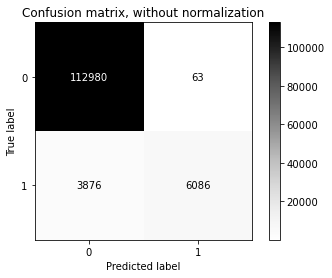

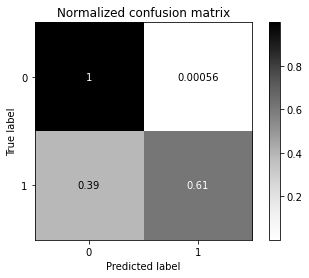

Decision Tree


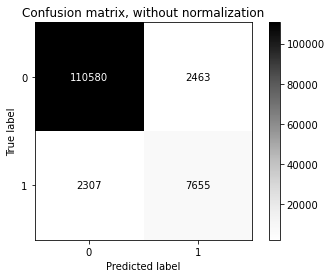

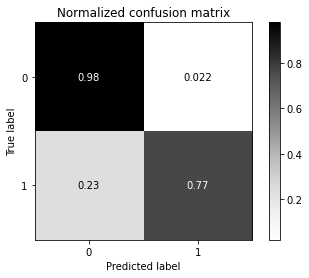

Light GBM


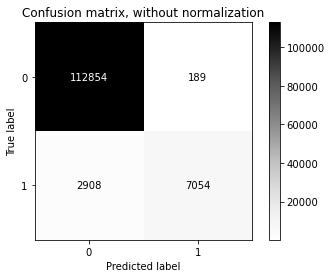

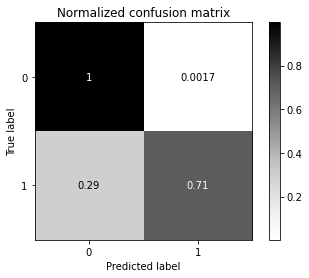

In [453]:
for model in [forest, tree, LGBM]:
    print('{}'.format(models_dict[model]))    
    plot_confusion_matrix(model)

### Parameter Tuning

In [ ]:
from sklearn.metrics import roc_curve, auc

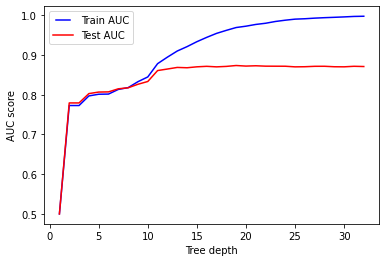

In [459]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=max_depth)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous train results
    train_results.append(roc_auc)
    y_pred = dt.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous test results
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

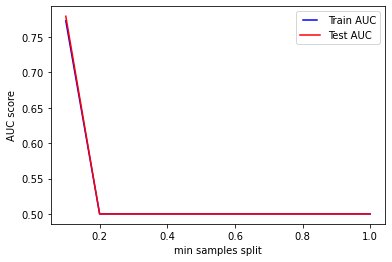

In [460]:
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
    dt = DecisionTreeClassifier(min_samples_split=min_samples_split)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = dt.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_splits, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples split')
plt.show()

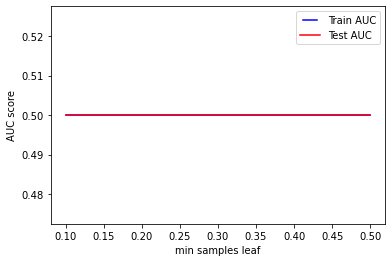

In [465]:
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
    dt = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = dt.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_leafs, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_leafs, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples leaf')
plt.show()

### Part 2: Evaluate algorithms using raw data 
    
   - K-Fold 
   - Confusion Matrix
   - Recall and precision
   - Algorthims
     - Logsitic Regression
     - KNN
     - Support Vector Machine
     - Random Forests
     - naive bayes

   

### SVM (Support Vector Machine)
-  Pros
    1. When the number of features/columns are higher, SVM does well
    2. Best algorithm when classes are separable.
    3. Outliers have less impact.
    4. SVM is suited for extreme case binary classification.  
   
- Cons:
    1. Slow: For larger dataset, it requires a large amount of time to process.
    2. Poor performance with Overlapped classes.
    3. Selecting appropriate hyperparameters is important: That will allow for sufficient generalization performance.
    4. Selecting the appropriate kernel function can be tricky.  
   
Applications:
Bag of words application(many features and columns), speech recognition data, classification of images(non-linear data), medical analytics(non linear data), text classification(many features)


### Part 3: Transform the features and evaluation

### Part 4:  Model Optimization ( Feature importance and parameter tuning)

#### Challenge 1: Imbalanced dataset
   
   only 8% of output is 1 (which means positive in this dataset) !
   
   ##### Why would this be an issue?   (explained by Google)
    With so few positives relative to negatives, the training model will spend most of its time on negative examples and not learn enough from positive ones.   
    If you have an imbalanced data set, first try training on the true distribution. If the model works well and generalizes, you're done! If not, try downsampling and upweighting technique.
   
   
   
   There are multiple ways dealing with imbalanced data. 
   - Try different algorithms
   - Transform dataset
       - Oversample (for small dataset)
       - Undersample (for big dataset)
   - and more...
   

   
   We will try these out in a second.

# _Pro & Cons for different algorithms_

Source: https://towardsdatascience.com/pros-and-cons-of-various-classification-ml-algorithms-3b5bfb3c87d6

### SVM (Support Vector Machine)
- Pros
  1. Performs well in Higher dimension. In real world there are infinite dimensions (and not just 2D and 3D). For instance image data, gene data, medical data etc. has higher dimensions and SVM is useful in that. Basically when the number of features/columns are higher, SVM does well
  2. Best algorithm when classes are separable. (when instances of both the classes can be easily separated either by a straight line or non-linearly). 
  3. Outliers have less impact.
  4. SVM is suited for extreme case binary classification.  

- Cons:
    1. Slow: For larger dataset, it requires a large amount of time to process.
    2. Poor performance with Overlapped classes.
    3. Selecting appropriate hyperparameters is important: That will allow for sufficient generalization performance.
    4. Selecting the appropriate kernel function can be tricky.  
    
Applications:
Bag of words application(many features and columns), speech recognition data, classification of images(non-linear data), medical analytics(non linear data), text classification(many features)


### Naive Bayes
 - Pros
    1. Real time predictions: It is very fast and can be used in real time.
    2. Scalable with Large datasets
    3. Insensitive to irrelevant features.
    4. Multi class prediction is effectively done in Naive Bayes
    5. Good performance with high dimensional data(no. of features is large)
 - Cons
    1. Independence of features does not hold: The fundamental Naive Bayes assumption is that each feature makes an independent and equal contribution to the outcome. However this condition is not met most of the times.
    2. Bad estimator: Probability outputs from predict_proba are not to be taken too seriously.
    3. Training data should represent population well: If you have no occurrences of a class label and a certain attribute value together (e.g. class=”No”, shape=”Overcast “) then the posterior probability will be zero. So if the training data is not representative of the population, Naive bayes does not work well.(This problem is removed by smoothening techniques).

Applications:
Naive Bayes is used in Text classification/ Spam Filtering/ Sentiment Analysis. It is used in text classification (it can predict on multiple classes and doesn’t mind dealing with irrelevant features), Spam filtering (identify spam e-mail) and Sentiment Analysis (in social media analysis, to identify positive and negative sentiments), recommendation systems (what will the user buy next)

### Logistic Regression
 - Pros
    1. Simple to implement
    2. Effective
    3. Feature scaling not needed: Does not require input features to be scaled (can work with scaled features too, but doesn’t require scaling)
    3. Tuning of hyperparameters not needed.
 - Cons
    1. Poor performance on non-linear data(image data for e.g)
    2. Poor performance with irrelevant and highly correlated features (use Boruta plot for removing similar or correlated features and irrelevant features).
    3. Not very powerful algorithm and can be easily outperformed by other algorithms.
    4. High reliance on proper presentation of data. All the important variables / features should be identified for it to work well.
Applications:
Any classification problem that is preferably binary (it can also perform multi class classification, but binary is preferred). For example you can use it if your output class has 2 outcomes; cancer detection problems, whether a student will pass/fail, default/no default in case of customer taking loan, whether a customer will churn or not, email is spam or not etc.

### Random Forest
 - Pros:
    1. Random forest can decorrelate trees. It picks the training sample and gives each tree a subset of the features(suppose training data was [1,2,3,4,5,6], so one tree will get subset of training data [1,2,3,2,6,6]. Note that size of training data remains same, both datas have length 6 and that feature ‘2’ and feature ‘6’ are repeated in the randomly sampled training data given to one tree. Each tree predicts according to the features it has. In this case tree 1 only has access to features 1,2,3 and 6 so it can predict based on these features. Some other tree will have access to features 1,4,5 say so it will predict according to those features. If features are highly correlated then that problem can be tackled in random forest.
    2. Reduced error: Random forest is an ensemble of decision trees. For predicting the outcome of a particular row, random forest takes inputs from all the trees and then predicts the outcome. This ensures that the individual errors of trees are minimized and overall variance and error is reduced.
    3. Good Performance on Imbalanced datasets : It can also handle errors in imbalanced data (one class is majority and other class is minority)
    4. Handling of huge amount of data: It can handle huge amount of data with higher dimensionality of variables.
    5. Good handling of missing data: It can handle missing data very well. So if there is large amount of missing data in your model, it will give good results.
    6. Little impact of outliers: As the final outcome is taken by consulting many decision trees so certain data points which are outliers will not have a very big impact on Random Forest.
    7. No problem of overfitting: In Random forest considers only a subset of features, and the final outcome depends on all the trees. So there is more generalization and less overfitting.
    8. Useful to extract feature importance (we can use it for feature selection)
 - Cons:
    1. Features need to have some predictive power else they won’t work.
    2. Predictions of the trees need to be uncorrelated.
    3. Appears as Black Box: It is tough to know what is happening. You can at best try different parameters and random seeds to change the outcomes and performance.
- Applications:
Credit card default, fraud customer/not, easy to identify patient’s disease or not, recommendation system for ecommerce sites.

### Decision Trees
 - Pros
    1. Normalization or scaling of data not needed.
    2. No considerable impact of missing values.
    3. Easy to explain to non-technical team members.
    4. Easy visualization
    5. Automatic Feature selection : Irrelevant features won’t affect decision trees.
 - Cons
    1. Prone to overfitting.
    2. Sensitive to data. If data changes slightly, the outcomes can change to a very large extent.
    3. Higher time required to train decision trees.
- Applications:
Identifying buyers for products, prediction of likelihood of default, which strategy can maximize profit, finding strategy for cost minimization, which features are most important to attract and retain customers (is it the frequency of shopping, is it the frequent discounts, is it the product mix etc), fault diagnosis in machines(keep measuring pressure, vibrations and other measures and predict before a fault occurs) etc.  


### XGBoost
 - Pros
    1. Less feature engineering required (No need for scaling, normalizing data, can also handle missing values well)
    2. Feature importance can be found out(it output importance of each feature, can be used for feature selection)
    3. Fast to interpret
    4. Outliers have minimal impact.
    5. Handles large sized datasets well.
    6. Good Execution speed
    7. Good model performance (wins most of the Kaggle competitions)
    8. Less prone to overfitting
 - Cons
    1. Difficult interpretation , visualization tough
    2. Overfitting possible if parameters not tuned properly.
    3. Harder to tune as there are too many hyperparameters.
- Applications
Any classification problem. Specially useful if you have too many features and too large datasets, outliers are present, there are many missing values and you don’t want to do much feature engineering. It wins almost all competitions so this is an algo you must definitely have in mind while solving any classification problem. 


### k-NN (K Nearest Neighbors)
 - Pros
    1. Simple to understand and impelment
    2. No assumption about data (for e.g. in case of linear regression we assume dependent variable and independent variables are linearly related, in Naïve Bayes we assume features are independent of each other etc., but k-NN makes no assumptions about data)
    3. Constantly evolving model: When it is exposed to new data, it changes to accommodate the new data points.
    4. Multi-class problems can also be solved.
    5. One Hyper Parameter: K-NN might take some time while selecting the first hyper parameter but after that rest of the parameters are aligned to it.
 - Cons
    1. Slow for large datasets.
    2. Curse of dimensionality: Does not work very well on datasets with large number of features.
    3. Scaling of data absolute must.
    4. Does not work well on Imbalanced data. So before using k-NN either undersamplemajority class or oversample minority class and have a balanced dataset.
    5. Sensitive to outliers.
    6. Can’t deal well with missing values
- Applications:
You can use it for any classification problem when dataset is smaller, and has lesser number of features so that computation time taken by k-NN is less. If you do not know the shape of the data and the way output and inputs are related (whether classes can be separated by a line or ellipse or parabola etc.), then you can use k-NN.

In [ ]:
# class dataframe():
    
#     def __init__(self,df: pd.DataFrame):
#         self.df = df 

#     def cols_selection(self, cols):
#         dftemp = self.df[cols]
#         return dftemp
    
#     def show_head(self):
#         dftemp = self.df.head()
#         return dftemp

#     def value_count(self, cols:list):
#         value_counts = self.df[cols].value_counts().sort_values(ascending = False)
#         return value_counts

#     def check_null(self):
#         all_cols = self.df.isnull().sum().sort_values(ascending = False)
#         null_cols = all_cols[all_cols > 0]
#         return null_cols

#     def check_null_percent(self):
#         #null_cols = check_null(self.df)
#         all_cols = self.df.isnull().sum().sort_values(ascending = False)
#         null_cols = all_cols[all_cols > 0]
#         null_percent = ((null_cols / len(self.df))* 100).round(3)
#         return null_percent

#     def index_to_list(self):
#         index_to_list = self.df.index.to_list()
#         return index_to_list

#     def drop_cols(self, cols:list):
#         self.df = self.df.drop(cols, axis = 1)


#     def drop_threshold_cols(self, threshold:int):
#        # null_percent = check_null_percent(self.df)
#         all_cols = self.df.isnull().sum().sort_values(ascending = False)
#         null_cols = all_cols[all_cols > 0]
#         null_percent = ((null_cols / len(self.df))* 100).round(3)
#         over_threshold_col = null_percent[null_percent > threshold]
#         over_threshold_col = over_threshold_col.index.to_list()
#         self.df = self.df.drop(over_threshold_col, axis = 1)


#     def fill_cols_zero(self, cols:list):
#         self.df[cols] = self.df[cols].fillna(value=0)

#     def fill_cols_mode(self, cols:list):
#         for col in cols:
#             self.df[col] = self.df[col].fillna(self.df[col].mode()[0])

#     def fill_cols_mean(self, cols:list):
#         for col in cols:
#             self.df[col] = self.df[col].fillna(self.df[col].mean())

#     def check_start(self, vals:list):
#         lst = []
#         cols = self.df.columns.to_list()
#         for col in cols:
#             for val in vals:
#                 if col.startswith(val):
#                     lst.append(col)
#         return lst

#     def check_end(self, vals:list):
#         lst = []
#         cols = self.df.columns.to_list()
#         for col in cols:
#             for val in vals:
#                 if col.endswith(val):
#                     lst.append(col)
#         return lst

#     def count_plot(self, col:list):
#         pl = 'cool'
#         fig, ax = plt.subplots(figsize=(13,5))
#         sns.countplot(x = col, data = self.df, palette = pl, ax = ax) 
        
#     def groupby_x_target_percent(self,x:str,hue:str):  
#         pl = 'cool'
#         groupbt_x_by_hue = (self.df
#         .groupby(x)[y]
#         .value_counts(normalize=True)
#         .mul(100)
#         .rename('percent')
#         .reset_index()
#         .pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar', palette = pl, height=9, aspect=1))
    
    
#     def checkout(self):
#             return self.df